## A very dirty but quick analysis of resting state networks on Gordon2014 atlas

In [71]:
# %pip install nilearn xarray seaborn tqdm pygal netcdf4 pynisher -q

Note: you may need to restart the kernel to use updated packages.


In [124]:
%reload_ext autoreload
%autoreload 3

from python.acnets.pipeline import Parcellation, NetworkAggregator
from python.acnets.pipeline import ConnectivityExtractor, ConnectivityVectorizer

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import  GridSearchCV, StratifiedShuffleSplit, permutation_test_score
import pandas as pd
import numpy as np
import pygal as pg
import xarray as xr

import seaborn as sns
import matplotlib.pyplot as plt

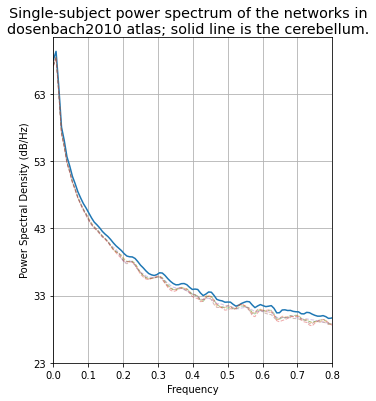

In [122]:
from nilearn.interfaces.bids import get_bids_files
from python.acnets.parcellations import gordon, dosenbach, difumo

img_files = get_bids_files(
    'data/julia2018/derivatives/fmriprep_2020',
    file_tag='bold',
    modality_folder='func',
    filters=[('ses', 'rest')],
    file_type='nii.gz')

# masker = maskers.NiftiLabelsMasker(
#     atlas.maps,
#     mask_img=mask_img,
#     # detrend=True,
#     # standardize=True,
#     t_r=3.0,
#     verbose=0)
# masker, labels = gordon.load_masker('gordon2014_2mm', None)
masker, labels = dosenbach.load_masker('dosenbach2010', None)
# masker, labels = difumo.load_masker('difumo_64_2mm', None)

# highlight_idx = labels.reset_index().query('network != "cerebellum"').index
# dmn_idx = labels.reset_index().query('network == "default"').index
# selected_idx = np.hstack((cerebellum_idx, dmn_idx))
# selected_idx = range(0,124)

n = NetworkAggregator(labels).fit()
highlight_idx = n.networks_

for img in img_files[:1]:
    ts = masker.fit().transform(img)
    ts = n.transform(ts).T
    highlight_idx = n.networks_.to_list().index('cerebellum')
    plt.subplots(1,1,figsize=(5,6))
    plt.subplot(111)
    lines = [plt.psd(tss, return_line=True) for tss in ts]
    lines = [line[0] for (_,_,line) in lines]
    for i,l in enumerate(lines):
        if i != highlight_idx: 
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_label('other')
            l.set_alpha(.4)
    plt.xlim(0, .8)
    plt.suptitle('Single-subject power spectrum of the networks in\ndosenbach2010 atlas; solid line is the cerebellum.', y=.95, fontsize='x-large')
    
    plt.show()

In [125]:
def extract_network_connectivity(X=None,
          atlas='gordon2014_2mm',
          connectivity='correlation',
          aggregate_networks=True):

    p = Parcellation(atlas)
    n = NetworkAggregator(p.labels_)
    c = ConnectivityExtractor(connectivity)

    if aggregate_networks:
        conn = make_pipeline(p, n, c).fit_transform(X)
        nodes = n.networks_.to_list()
    else:
        conn = make_pipeline(p, c).fit_transform(X)
        nodes = p.labels_.index.to_list()


    conn = xr.DataArray(
        conn,
        coords={'subject': p.dataset_['subject'],
                'node': nodes},
        dims=['subject', 'node', 'node'],
        name='connectivity')

    if X is not None:
        conn = conn.sel(dict(subject=X.reshape(-1).tolist()))

    return conn


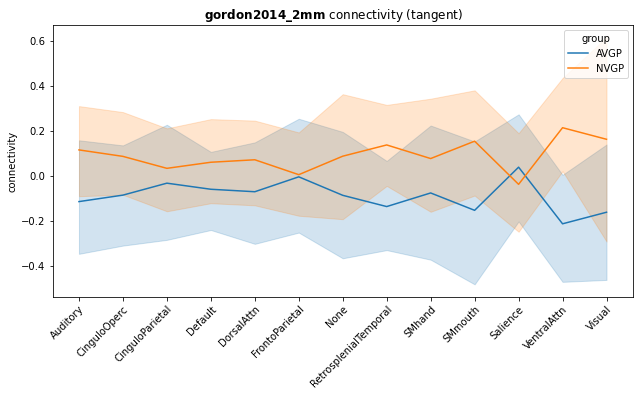

In [131]:
_atlas = 'gordon2014_2mm'
_connectivity = 'tangent'
conn = extract_network_connectivity(atlas=_atlas, connectivity=_connectivity)
subjects = conn.coords['subject'].values
subject_groups = np.array([s[:4] for s in subjects])
conn_vec = ConnectivityVectorizer(only_diagonal=True).fit_transform(conn)

df = pd.DataFrame(conn_vec, columns=conn.coords['node'].values)
df['group'] = subject_groups

df = df.melt(id_vars=['group'], var_name='network', value_name='connectivity')

# df['group_mean'] = df.groupby(['network'])['connectivity'].transform('mean')
# df.sort_values(by='group_mean', ascending=False, inplace=True)

n_networks = df['network'].nunique()

_, ax = plt.subplots(figsize=(n_networks * .8, 5))
sns.lineplot(data=df, x='network', y='connectivity', hue='group', sort=False)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')

_atlas = _atlas.replace('_','\_')
plt.suptitle(f'$\\bf{{{_atlas}}}$ connectivity ({_connectivity})', y=.93)
plt.xlabel('')
plt.show()

/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_42285/1162345493.py:29: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x138de7460> has a label of '_average' which cannot be automatically added to the legend.
  lgd = ax.legend(['average', '95% CI', '_average', 'chance'],


<Figure size 432x288 with 0 Axes>

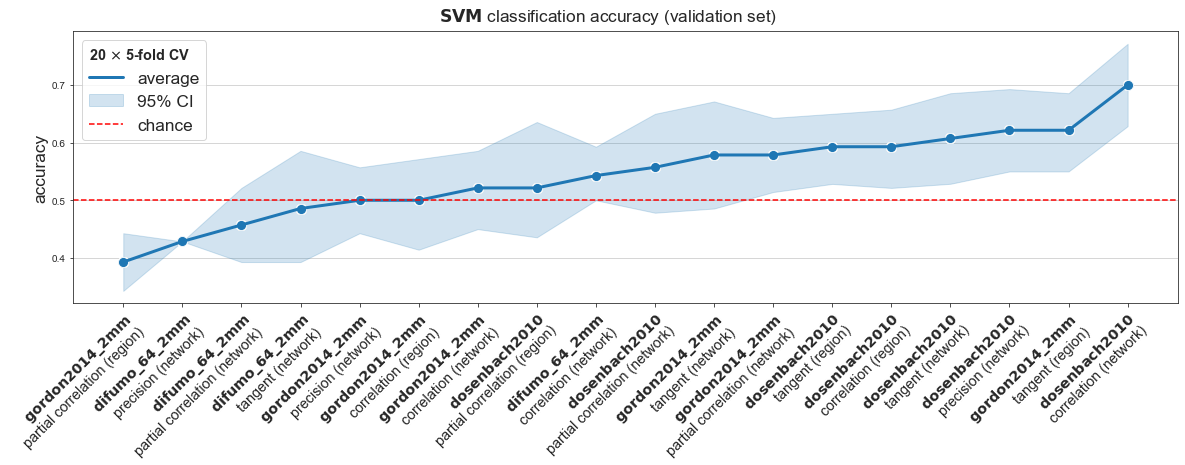

In [218]:


def plot_grid_search_results(grid, score_name='accuracy'):
    sns.set_style('ticks')
    sns.despine()

    results = grid.cv_results_
    n_splits = grid.cv.get_n_splits()

    param_names = []
    for param in results['param_connectivity__kw_args']:
        atlas = param['atlas'].replace('_','\_')
        connectivity = param['connectivity']
        feature = 'network' if param['aggregate_networks'] else 'region' 
        param_names.append(f'$\\bf{{{atlas}}}$\n{connectivity} ({feature})')

    cv_scores = []
    for i in range(n_splits):
        scores = results[f'split{i}_test_score']
        cv_scores.extend(list(zip(param_names, scores)))

    test_results  = pd.DataFrame(cv_scores, columns=['parcellation', score_name])
    test_results['mean_score'] = test_results.groupby('parcellation').transform(np.mean)
    test_results.sort_values('mean_score', ascending=False, inplace=True)
    # DEBUG print(test_results.groupby('parcellation').min())

    _, ax = plt.subplots(figsize=(len(param_names) * 1.1, 5))
    sns.lineplot(data=test_results.iloc[::-1], x='parcellation', y=score_name, lw=3, sort=False, ax=ax)
    sns.scatterplot(data=test_results.iloc[::-1], x='parcellation', y='mean_score', marker='o', s=100,ax=ax)
    ax.axhline(.5, linestyle='--', color='red')
    lgd = ax.legend(['average', '95% CI', '_average', 'chance'],
                    title_fontproperties={'weight':'bold', 'size':'x-large'},
                    prop={'size':'xx-large'},
                    title=f'{n_splits} $\\times$ 5-fold CV')
    ax.get_legend()._legend_box.align = 'left'
    ax.set_xlabel('')
    ax.set_ylabel('accuracy', fontsize='xx-large')
    plt.xticks(rotation=45, ha='right', fontsize='x-large', rotation_mode='anchor')
    plt.suptitle('$\\bf{SVM}$ classification accuracy (validation set)', fontsize='xx-large', y=.95)
    plt.grid(axis='y')

    # table = plt.table(cellText=[['s','s2','s3','s4','s5'],['s','s2','s','s','s']],
    #                   rowLabels=['atlas','connectivity'],
    #                   rowColours=['lightgreen','gray'],
    #                 #   colLabels=['1','2'],
    #                 colLoc=['center','center'],
    #                   loc='bottom')

    plt.show()

plot_grid_search_results(grid)

Fitting 20 folds for each of 18 candidates, totalling 360 fits
[CV 1/20] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': False};, score=0.857 total time=   1.0s
[CV 2/20] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': False};, score=0.429 total time=   1.1s
[CV 3/20] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': False};, score=0.429 total time=   1.1s
[CV 4/20] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': False};, score=0.429 total time=   1.1s
[CV 5/20] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': False};, score=0.286 total time=   1.3s
[CV 6/20] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': False};, score=0.429 total time=   

<Figure size 432x288 with 0 Axes>

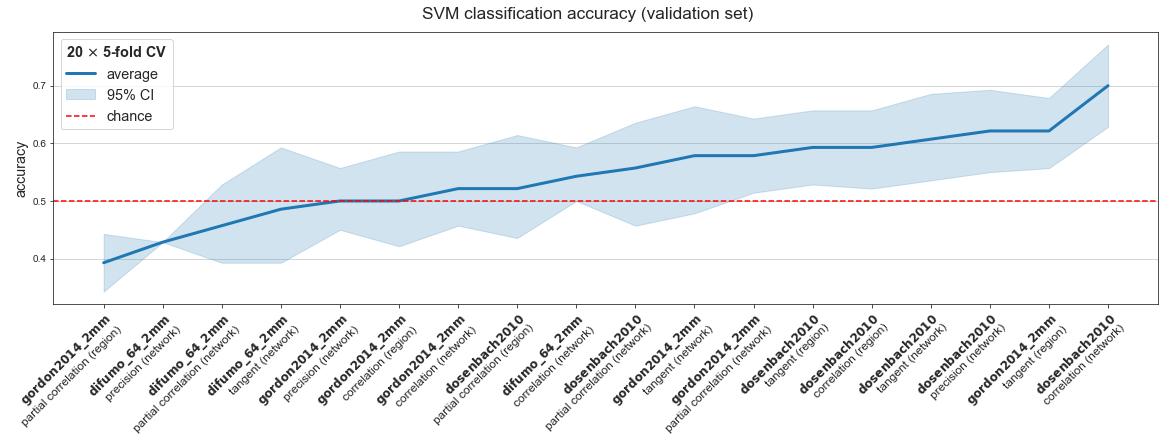

In [136]:
pipe  = Pipeline([
    ('connectivity', FunctionTransformer(extract_network_connectivity)),
    ('vectorize', ConnectivityVectorizer()),
    # ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('select', SelectFromModel(LinearSVC(C=5, max_iter=100000))),
    ('zv', VarianceThreshold(threshold=0)),
    # ('svm', SVC(kernel='linear', probability=True))
    ('svm', LinearSVC(C=.1, max_iter=100000))
    # ('rfc', RandomForestClassifier())
])


params = {
    'connectivity__kw_args': [
        
        dict(atlas='gordon2014_2mm', connectivity='correlation', aggregate_networks=False),
        dict(atlas='gordon2014_2mm', connectivity='tangent', aggregate_networks=False),
        dict(atlas='gordon2014_2mm', connectivity='partial correlation', aggregate_networks=False),

        dict(atlas='gordon2014_2mm', connectivity='correlation', aggregate_networks=True),
        dict(atlas='gordon2014_2mm', connectivity='tangent', aggregate_networks=True),
        dict(atlas='gordon2014_2mm', connectivity='precision', aggregate_networks=True),
        dict(atlas='gordon2014_2mm', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='chatterjee', aggregate_networks=True),

        dict(atlas='dosenbach2010', connectivity='correlation', aggregate_networks=False),
        dict(atlas='dosenbach2010', connectivity='tangent', aggregate_networks=False),
        dict(atlas='dosenbach2010', connectivity='partial correlation', aggregate_networks=False),

        dict(atlas='dosenbach2010', connectivity='correlation', aggregate_networks=True),
        dict(atlas='dosenbach2010', connectivity='tangent', aggregate_networks=True),
        dict(atlas='dosenbach2010', connectivity='precision', aggregate_networks=True),
        dict(atlas='dosenbach2010', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='chatterjee', aggregate_networks=True),

        dict(atlas='difumo_64_2mm', connectivity='correlation', aggregate_networks=True),
        dict(atlas='difumo_64_2mm', connectivity='tangent', aggregate_networks=True),
        dict(atlas='difumo_64_2mm', connectivity='precision', aggregate_networks=True),
        dict(atlas='difumo_64_2mm', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='chatterjee', aggregate_networks=True)

    ],
    # 'select__estimator__C': [0.1, .3, .5, 1, 3, 5],
    # 'svm__C': [0.1, .3, .5, 1, 3, 5],
    # 'svm__kernel': ['linear', 'rbf'],
}

subjects = extract_network_connectivity().coords['subject'].values
y = np.array([s[:4] for s in subjects])
X = subjects.reshape(-1, 1)

cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2)

grid = GridSearchCV(pipe, params, verbose=3, cv=cv, scoring='accuracy')
grid.fit(X, y)
print(grid.best_estimator_)
plot_grid_search_results(grid)

In [48]:
# Cross-correlation (DEBUG)

import sklearn
sklearn.set_config(display='diagram')
pipe

import statsmodels.api as sm
sm.tsa.stattools.ccf([1,2,3,4,5,6,7,8,0], [0,0,1,2,3,4,5,6,7], adjusted=True)

array([ 3.72787591e-01,  1.33138425e-01, -1.26798500e-01, -3.90539381e-01,
       -6.28413368e-01, -7.81078763e-01, -7.10071602e-01, -5.67603246e-16,
        1.98820049e+00])

# Permutation testing

In [ ]:
# DEBUG
# grid.best_estimator_.named_steps['select'].estimator_.coef_
obs_score, perm_scores, pvalue = permutation_test_score(grid.best_estimator_, X, y, scoring='accuracy', n_permutations=100)


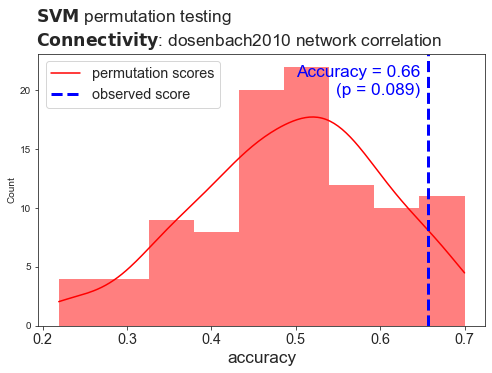

In [212]:
_, ax = plt.subplots(figsize=(8,5))
g = sns.histplot(perm_scores, kde=True, ax=ax, color='red', lw=0)
ax.axvline(obs_score, ls='--', color='blue', lw=3)
plt.xlabel('accuracy', fontsize='xx-large')
plt.xticks(fontsize='x-large')
ax.text(x=obs_score - .01,
        y=ax.get_ylim()[1] * .85,
        ha='right',
        color='blue',
        s=f'Accuracy = {obs_score:.2f}\n(p = {pvalue:.3f})', fontsize='xx-large')

plt.suptitle('$\\bf{SVM}$ permutation testing\n$\\bf{Connectivity}$: dosenbach2010 network correlation',
             ha='left',
             x = 0.12,
             y=1.01, fontsize='xx-large')
plt.legend(['permutation scores', 'observed score'], loc='upper left', fontsize='x-large')
plt.show()

In [83]:
try:
    from autosklearn.classification import AutoSklearnClassifier

    subjects = extract_network_connectivity().coords['subject'].values
    y = np.array([s[:4] for s in subjects])
    X = subjects.reshape(-1, 1)

    train, test = StratifiedShuffleSplit(n_splits=1, test_size=0.2).split(X, y).__next__()

    # pipeline
    automl_pipe  = Pipeline([
    ('connectivity', FunctionTransformer(
        extract_network_connectivity,
        kw_args=dict(atlas='dosenbach2010',
                     connectivity='correlation',
                     aggregate_networks=True))),
    ('vectorize', ConnectivityVectorizer()),
    ('automl', AutoSklearnClassifier(time_left_for_this_task=30))
    ], verbose=0)

    # perform pipeline on all parcellations
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
    automl_grid = GridSearchCV(automl_pipe, params, verbose=2, cv=cv, scoring='accuracy')
    automl_grid.fit(X, y)
    plot_grid_search_results(automl_grid)

except Exception as e:
    print(e)

No module named 'autosklearn'


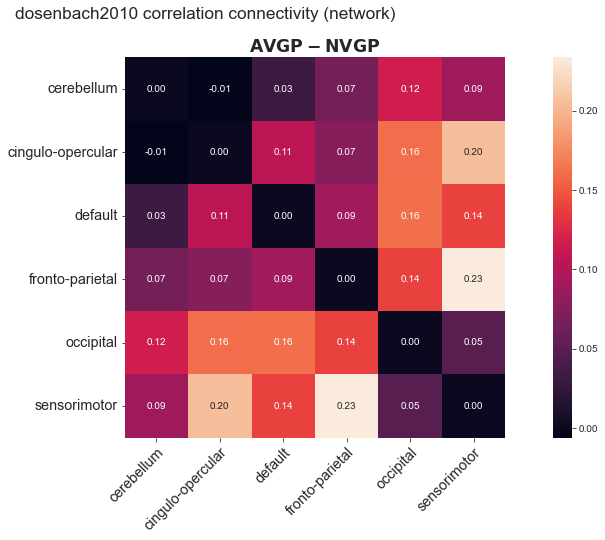

In [261]:

def plot_connectivity_heatmap(all_conns, title, plot_diff, ax):

    if plot_diff:
        avgp = conn.subject.str.contains("AVGP").values
        data = conn[avgp].mean(dim='subject').values - conn[~avgp].mean(dim='subject').values
    else:
        data = all_conns.mean(dim='subject')

    sns.heatmap(
        data,
        yticklabels=conn.coords['node'].values,
        xticklabels=conn.coords['node'].values,
        annot=True, fmt='.2f',
        ax=ax,
        square=True,
        # figsize=(7, 7),
        # dendrogram_ratio=0.001,
        # cbar_pos=(1., 0.3, 0.03, 0.6)
        # cmap='rainbow',
        # cbar=False,
    )
    ax.set_title(f'$\\bf{{{title}}}$', fontsize='xx-large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize='x-large')
    ax.set_yticklabels(ax.get_xticklabels(), rotation=0, ha='right', rotation_mode='anchor', fontsize='x-large')


conn = extract_network_connectivity(atlas='dosenbach2010', connectivity='correlation')
avgp = conn.subject.str.contains("AVGP").values

fig, axes = plt.subplots(1, 1, figsize=(17, 7))
# plot_connectivity_heatmap(conn[avgp], title='AVGP', plot_diff=False, ax=axes[0])
# plot_connectivity_heatmap(conn[~avgp], title='NVGP', plot_diff=False, ax=axes[1])
plot_connectivity_heatmap(conn[~avgp], title='AVGP - NVGP', plot_diff=True, ax=axes)

plt.suptitle('dosenbach2010 correlation connectivity (network)', fontsize='xx-large')
plt.show()

In [ ]:
chart = pg.Line(_self_close=False, _max=10)

for (network,subject),data  in network_timeseries['timeseries_mean'].iteritems():
  if network in ['Visual','FrontoParietal']:
    chart.add(network, data)

from IPython.display import SVG
SVG(chart.render())

# Again, a very dirty but quick EPI signal level in Cerebellum

Is it clear that there is an appreciable reduction of tSNR in the brainstem and cerebellum compared to the cerebrum, caused by lower mean signal and/or increased signal variance in the those regions (as measured by tSNR)?

In [51]:
from nilearn import image, plotting, maskers
from tqdm  import tqdm
import nibabel as nib 
from pathlib import Path
import datalad.api as dlapi
import numpy as np
import pandas as pd

tsnr_images = []

# fmriprep
dataset = dlapi.Dataset('data/julia2018/derivatives/fmriprep_2020')
scan_imgs = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')
mask_imgs = Path(dataset.path).glob('sub-*/ses-rest/func/*-brain_mask.nii.gz')
# raw
# dataset = dlapi.Dataset('data/julia2018')
# scan_imgs  = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')


for img, mask_img in tqdm(zip(scan_imgs,  mask_imgs)):
  dlapi.get(img)
  dlapi.get(mask_img)

  img = nib.load(img)
  mask_img = nib.load(mask_img)

  masker = maskers.NiftiMasker(mask_img)
  masked_img = masker.fit_transform(img)
  masked_img = masker.inverse_transform(masked_img)

  data_avg = np.mean(masked_img.get_fdata(), axis=-1)
  data_std = np.std(masked_img.get_fdata(), axis=-1)
  tsnr = data_avg / data_std
  tsnr = np.where(data_std > 0.0, tsnr, 0.0)
  tsnr_img = nib.nifti1.Nifti1Image(tsnr, masked_img.affine)

  tsnr_images.append(tsnr_img)


0it [00:00, ?it/s]/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_4213/1895531294.py:33: RuntimeWarning: invalid value encountered in true_divide
  tsnr = data_avg / data_std
1it [00:02,  2.14s/it]/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_4213/1895531294.py:33: RuntimeWarning: invalid value encountered in true_divide
  tsnr = data_avg / data_std
2it [00:04,  2.09s/it]/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_4213/1895531294.py:33: RuntimeWarning: invalid value encountered in true_divide
  tsnr = data_avg / data_std
3it [00:06,  2.21s/it]/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_4213/1895531294.py:33: RuntimeWarning: invalid value encountered in true_divide
  tsnr = data_avg / data_std
4it [00:08,  2.17s/it]/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/ipykernel_4213/1895531294.py:33: RuntimeWarning: invalid value encountered in true_divide
  tsnr = data_avg / data_std
5it [00:10,  2.12s/it]/var/folders/3_/gmvd1nkx285133z5

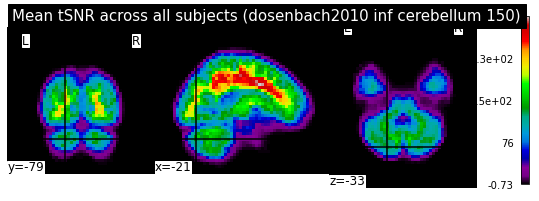

In [54]:
# only works on fmriprep 

from nilearn import image
import nibabel as nib

mean_tsnr_img = image.mean_img(tsnr_images)


plotting.plot_epi(mean_tsnr_img, cut_coords=(-21,-79,-33),
                    black_bg=False,
                    colorbar=True,
                    title=f'Mean tSNR across all subjects (dosenbach2010 inf cerebellum 150)',
)

In [55]:
from nilearn.datasets import fetch_coords_dosenbach_2010

atlas = fetch_coords_dosenbach_2010(legacy_format=False)

labels = pd.DataFrame(atlas.labels)
labels['network'] = atlas.networks.reset_index(drop=True)
# atlas.networks
# atlas.rois
labels[['x','y','z']] =  atlas.rois.reset_index(drop=True)
cerebellum_rois = labels.query('network == "cerebellum"')
cerebellum_rois

,0,network,x,y,z
0,inf cerebellum 155,cerebellum,18,-81,-33
1,inf cerebellum 150,cerebellum,-21,-79,-33
2,inf cerebellum 151,cerebellum,-6,-79,-33
3,inf cerebellum 140,cerebellum,33,-73,-30
4,inf cerebellum 131,cerebellum,-34,-67,-29
5,inf cerebellum 122,cerebellum,32,-61,-31
6,inf cerebellum 121,cerebellum,-25,-60,-34
7,inf cerebellum 110,cerebellum,-37,-54,-37
8,lat cerebellum 128,cerebellum,21,-64,-22
9,lat cerebellum 113,cerebellum,-34,-57,-24


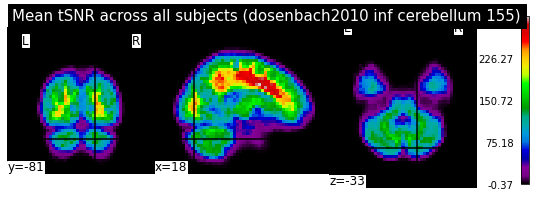

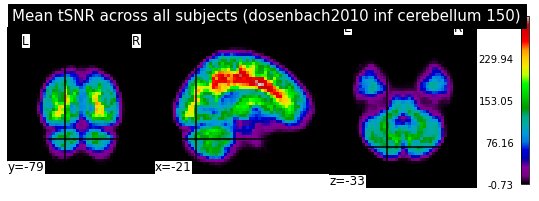

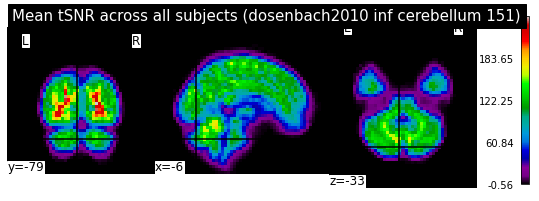

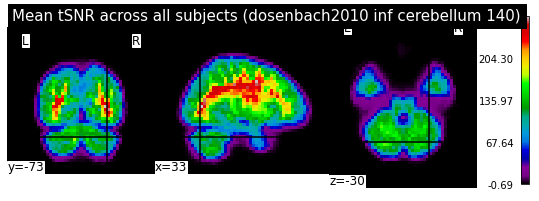

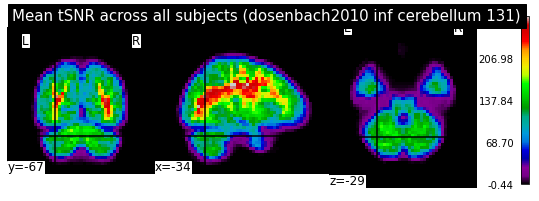

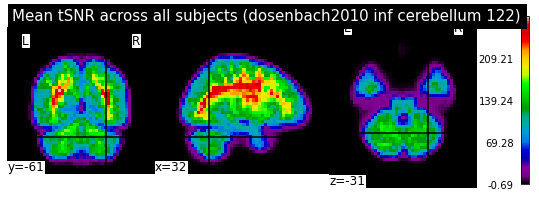

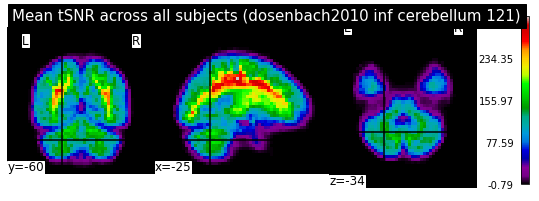

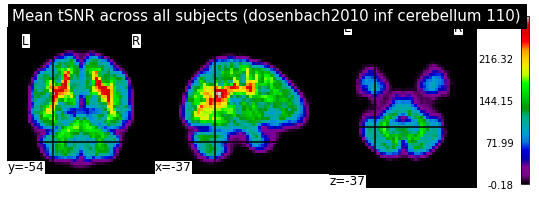

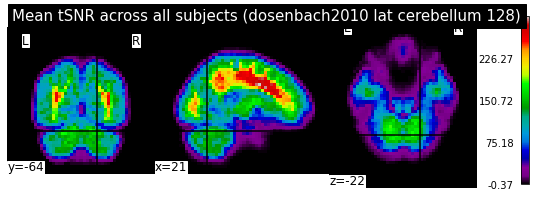

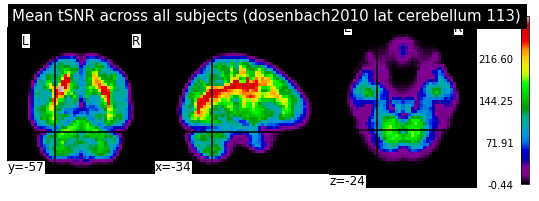

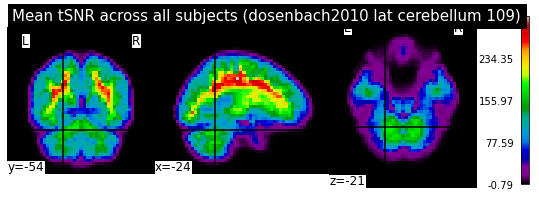

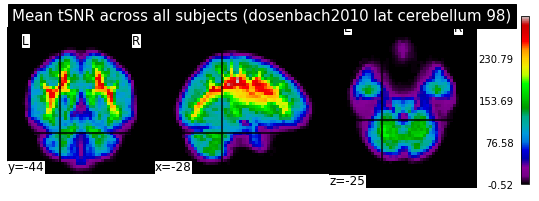

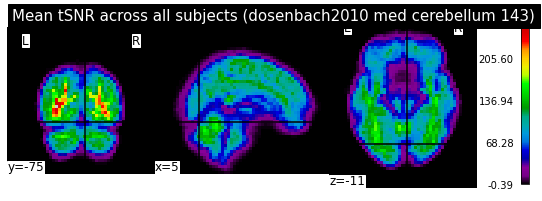

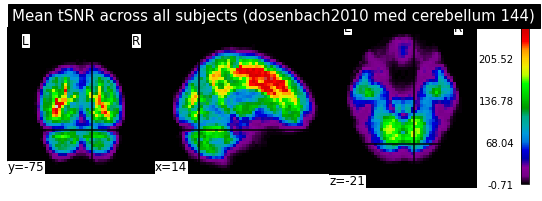

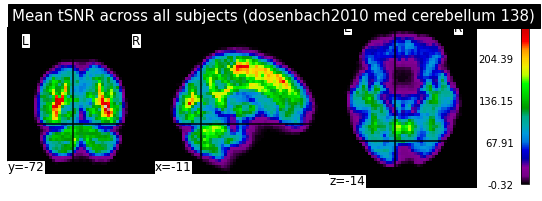

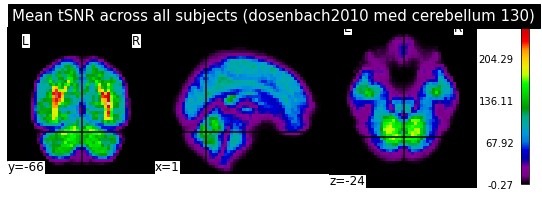

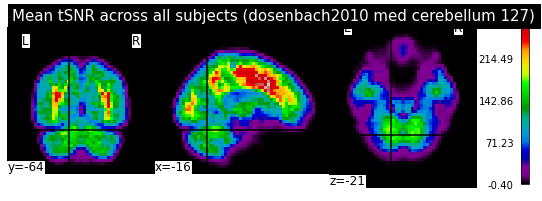

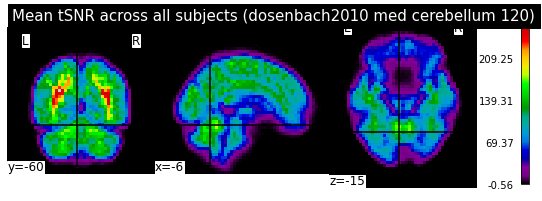

In [59]:

for _,roi,network,x,y,z  in cerebellum_rois.itertuples():
    plotting.plot_epi(mean_tsnr_img, colorbar=True,
                    # cut_coords=(18,-81,-32),
                    cut_coords=(x,y,z),
                    # cmap='cold_hot',
                    black_bg=False,
                    title=f'Mean tSNR across all subjects (dosenbach2010 {roi})',
                    cbar_tick_format='%.2f')
    plotting.show()

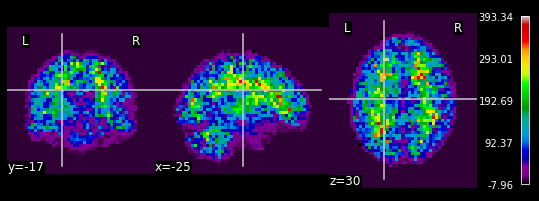

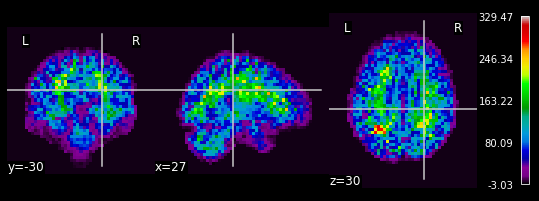

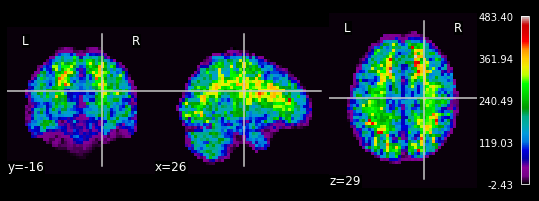

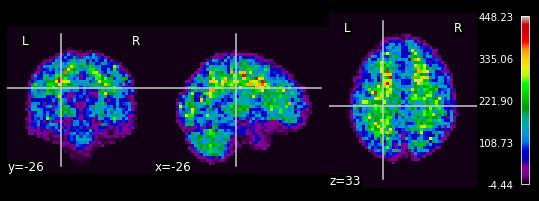

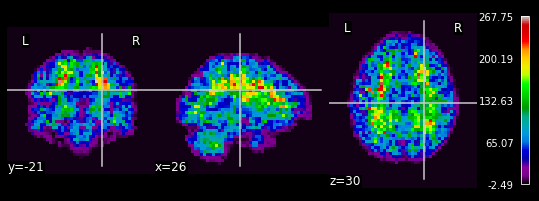

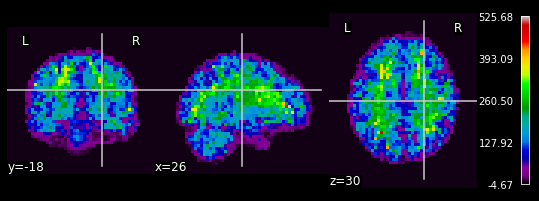

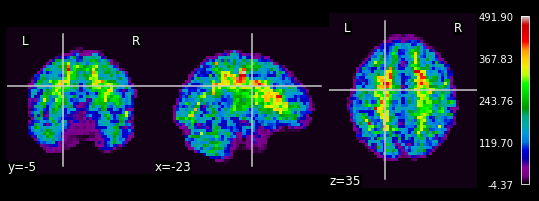

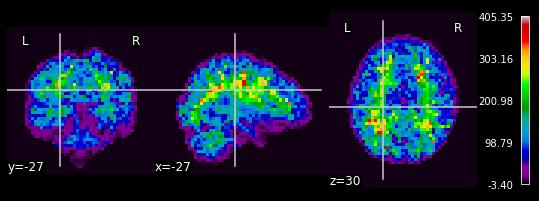

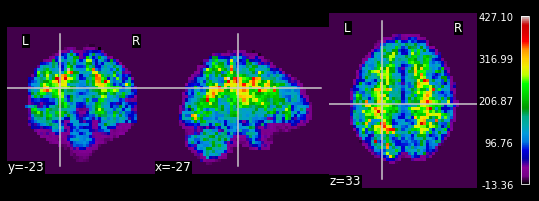

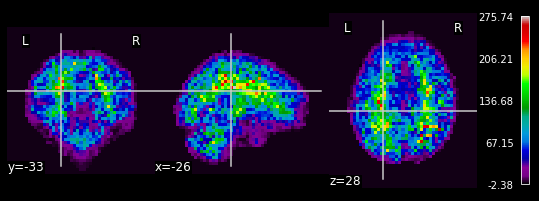

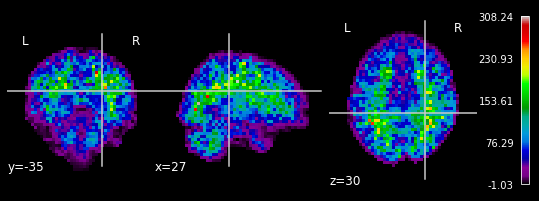

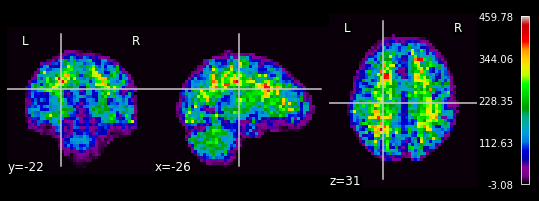

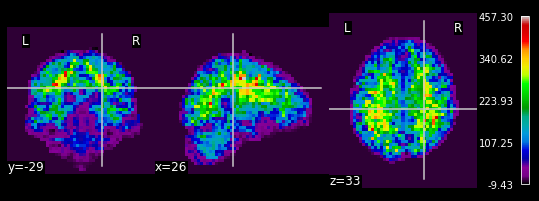

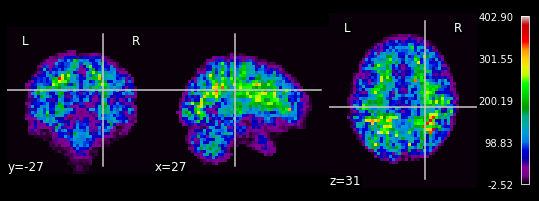

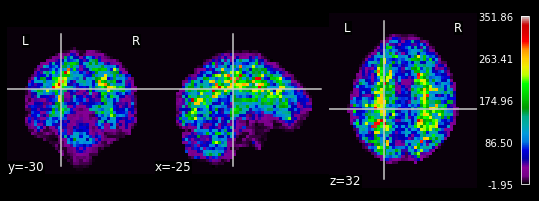

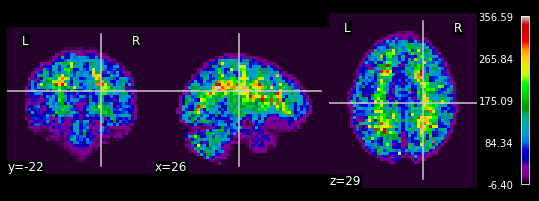

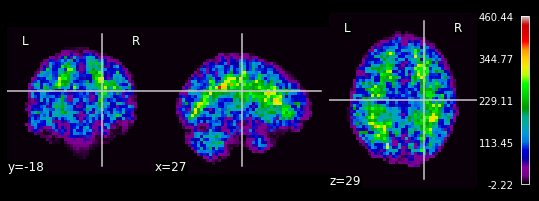

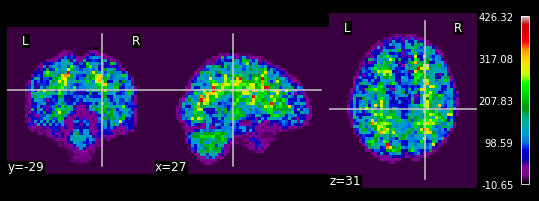

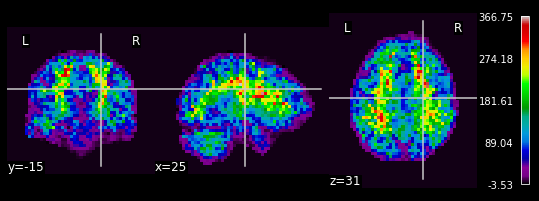

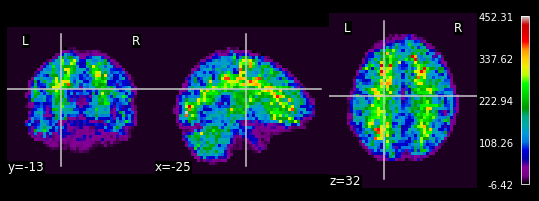

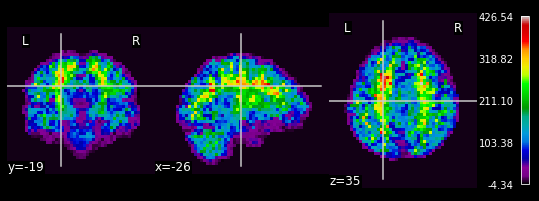

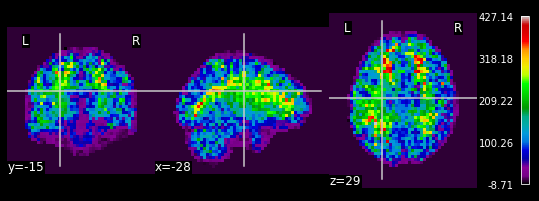

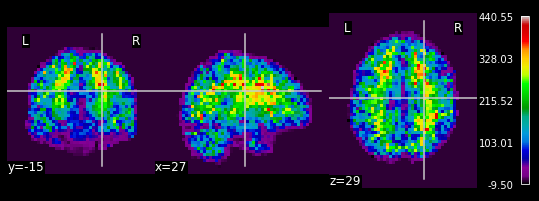

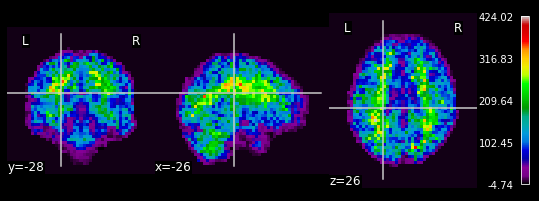

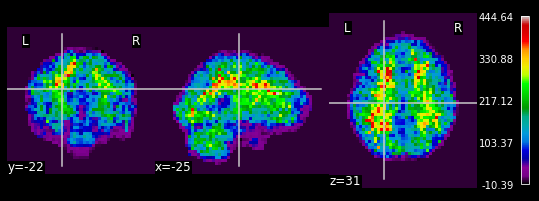

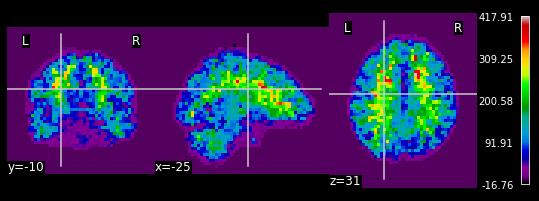

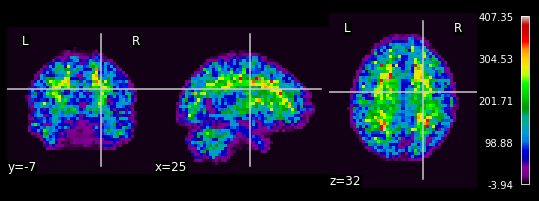

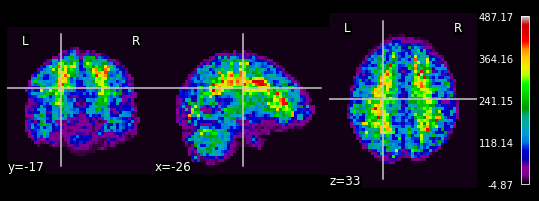

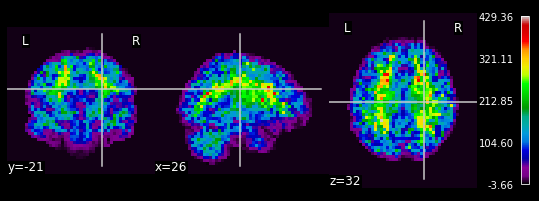

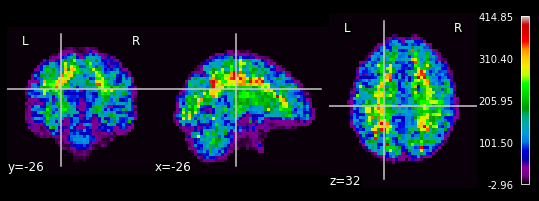

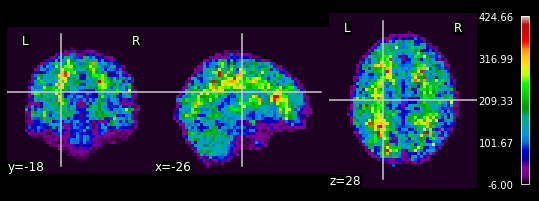

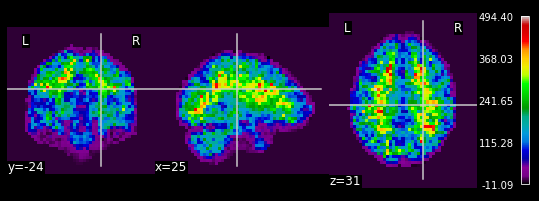

In [60]:
for tsnr_img in tsnr_images:
    plotting.plot_epi(tsnr_img, colorbar=True,
                    # cut_coords=(0,-60,-25),
                    # cmap='cold_hot',
                    cbar_tick_format='%.2f')
    plotting.show()

## Dirty Network masker

In [61]:
from nilearn import maskers, datasets, plotting, image, surface
import numpy as np
from python.acnets.parcellations import gordon

atlas = gordon.fetch_atlas()

maps_data = image.get_data(atlas['maps'])
atlas.labels['network'] = atlas.labels['network'].astype('category')
region2network_mapping = atlas.labels['network'].cat.codes + 1
region2network_mapping = region2network_mapping.to_dict()
# atlas.labels['network'].cat.categories
none_regions = atlas.labels.query('network == "None"').index
none_idx = atlas.labels['network'].cat.categories.to_list().index('None') + 1
map_r2n = lambda x: region2network_mapping[int(x)] if x not in [0,none_idx] else 0
maps_data = np.vectorize(map_r2n)(maps_data)

new_maps = image.new_img_like(atlas['maps'], maps_data)
new_maps.to_filename('a.nii.gz')

fsaverage = datasets.fetch_surf_fsaverage()

# plotting.plot_epi(new_maps, colorbar=True)
# plotting.plot_img(new_maps, colorbar=True)
# plotting.plot_roi(new_maps, title='Gordon Atlas', colorbar=True)

# aa = surface.vol_to_surf(new_maps, fsaverage.pial_left)

# plotting.view(fsaverage['pial_left'], roi_map=aa,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5)

plotting.view_img(new_maps, symmetric_cmap=False).open_in_browser()

# plotting.view_surf(fsaverage.white_right, aa).open_in_browser()
# plotting.plot_glass_brain(new_maps, colorbar=True, annotate=True)
# plotting.plot_epi(net_maps,cut_coords=(0,-10,-55), colorbar=True)

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
